# fMRI Decoding of Thoracic versus Lumbosacral Back Stimulation 
## Linear Support Vector Classifier

**Author:** Monika Doerig, 8 Oct 2025  

[<img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" width="20"> MoniDoerig](https://github.com/MoniDoerig)

[<img src="https://info.orcid.org/wp-content/uploads/2019/11/orcid_16x16.png" width="20"> 0009-0008-3617-2185](https://orcid.org/0009-0008-3617-2185)


In [1]:
import os, glob
import numpy as np
from nilearn.image import concat_imgs, math_img, resample_to_img, load_img
from nilearn.decoding import Decoder
from nilearn import image, datasets, masking, plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.model_selection import GridSearchCV, StratifiedKFold, permutation_test_score, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from nilearn.maskers import NiftiMasker


import warnings
# ignore all UserWarnings and RuntimeWarnings globally
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [2]:
# -----------------
# 1. Import Data
# -----------------

base_dir = '/mnt/neurodesktop-storage/Analysis/SPM/Workflows/level1_spm_3T_ML/level1_spm_results_ML'

# Healthy controls
hc_con26 = sorted(glob.glob(os.path.join(base_dir, "HC*/con_0003.nii")))  # upper back
hc_con27 = sorted(glob.glob(os.path.join(base_dir, "HC*/con_0004.nii")))  # lower back

hc_imgs_T_L = hc_con26 + hc_con27
hc_labels = ["upper"] * len(hc_con26) + ["lower"] * len(hc_con27)

# Patients
pat_con26 = sorted(glob.glob(os.path.join(base_dir, "PAT*/con_0003.nii")))
pat_con27 = sorted(glob.glob(os.path.join(base_dir, "PAT*/con_0004.nii")))

pat_imgs_T_L = pat_con26 + pat_con27
pat_labels = ["upper"] * len(pat_con26) + ["lower"] * len(pat_con27)

In [3]:
# -----------------
# 2. Encode labels
# -----------------
le = LabelEncoder()
hc_y = le.fit_transform(hc_labels)  # 0 = lower, 1 = upper
pat_y = le.transform(pat_labels)

# -----------------
# 3. Define mask
# -----------------
mask_S1M1_path = "/mnt/neurodesktop-storage/Siibra_masks/all_regs_1to5_BL_bin.nii.gz" # roi_mask

# Load masks
mask_S1M1 = load_img(mask_S1M1_path)

# -----------------
# 4. Load and preprocess images
# -----------------
hc_niimgs_T_L = concat_imgs(hc_imgs_T_L)
pat_niimgs_T_L = concat_imgs(pat_imgs_T_L)

# Replace NaNs/Infs with 0
hc_niimgs_clean_T_L = math_img("np.nan_to_num(img)", img=hc_niimgs_T_L)
pat_niimgs_clean_T_L = math_img("np.nan_to_num(img)", img=pat_niimgs_T_L)

# Resample masks to match images
mask_resampled_S1M1 = resample_to_img(mask_S1M1, hc_niimgs_clean_T_L, interpolation="nearest", copy_header=True, force_resample=True)

mni_mask = datasets.load_mni152_brain_mask()
mni_mask_resampled = image.resample_to_img(mni_mask, mask_resampled_S1M1, interpolation="nearest", 
                                           copy_header=True, force_resample=True)

# Intersect: ROI ∩ MNI brain
roi_mask_in_brain = image.math_img("roi * brain",
                                   roi=mask_resampled_S1M1,
                                   brain=mni_mask_resampled)

# Save or use this refined ROI
roi_mask_in_brain.to_filename("roi_mask_in_brain.nii.gz")

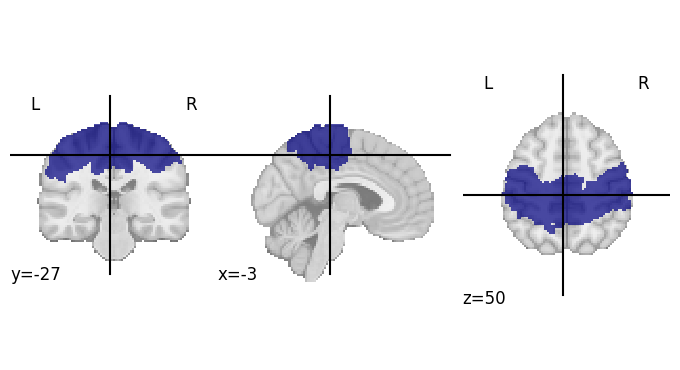

In [4]:
#Visualize ROI mask
plotting.plot_roi(roi_mask_in_brain, colorbar=False)

## LinearSVC with Feature Selection, Hyperparameter Tuning (C) and nested CV

In [5]:
# Data
X_hc = hc_niimgs_clean_T_L
X_pat = pat_niimgs_clean_T_L
mask_img = roi_mask_in_brain

# Titles
ds_name = "T_L"
mask_name = "S1M1"

print(f"\n=== Dataset: {ds_name} ===")
print(f"--- Mask: {mask_name} ---")

# Nested CV settings
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Transform to feature space
masker = NiftiMasker(mask_img=mask_img, standardize=True)
X_hc_mat = masker.fit_transform(X_hc)
X_pat_mat = masker.transform(X_pat)

# Parameter grid for ROI mask (using 100% screening since ROI mask)
param_grid = {"anova__percentile": [100], "svc__C": [0.01, 0.1, 1, 10]}

# Define pipeline
pipe = Pipeline([
    ("anova", SelectPercentile(f_classif)),
    ("svc", LinearSVC(penalty="l2", dual=True, max_iter=5000))
])

# Nested CV on HC
grid = GridSearchCV(pipe, param_grid, cv=inner_cv,
                    scoring="accuracy", n_jobs=-1)
nested_scores = cross_val_score(grid, X_hc_mat, hc_y,
                                cv=outer_cv, scoring="accuracy", n_jobs=-1)
print(f"HC nested CV accuracy: {nested_scores.mean():.3f} ± {nested_scores.std():.3f}")

# Refit best model
grid.fit(X_hc_mat, hc_y)
best_model = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Evaluate on PAT
y_pred = best_model.predict(X_pat_mat)
pat_bal_acc = accuracy_score(pat_y, y_pred)
print(f"PAT balanced accuracy: {pat_bal_acc:.3f}")
print("Classification report:\n", classification_report(pat_y, y_pred))
print("Confusion matrix:\n", confusion_matrix(pat_y, y_pred))

# Weight map
feature_selector = best_model.named_steps["anova"]
svc = best_model.named_steps["svc"]

# Initialize a full-size weight vector (all zeros)
full_coef = np.zeros(masker.n_elements_)

# Fill only the selected feature positions
full_coef[feature_selector.get_support()] = svc.coef_.ravel()

# Inverse transform to brain space
coef_img = masker.inverse_transform(full_coef)
coef_img.to_filename("SVM_weights.nii.gz")


=== Dataset: T_L ===
--- Mask: S1M1 ---
HC nested CV accuracy: 0.729 ± 0.119
Best parameters: {'anova__percentile': 100, 'svc__C': 0.01}
PAT balanced accuracy: 0.778
Classification report:
               precision    recall  f1-score   support

           0       0.74      0.87      0.80        45
           1       0.84      0.69      0.76        45

    accuracy                           0.78        90
   macro avg       0.79      0.78      0.78        90
weighted avg       0.79      0.78      0.78        90

Confusion matrix:
 [[39  6]
 [14 31]]


#### Permutation Test

In [ ]:
n_perm = 5000
perm_acc = []
for i in range(n_perm):
    y_hc_perm = shuffle(hc_y, random_state=i)
    
    # Retrain model on shuffled HC labels
    grid_perm = GridSearchCV(pipe, param_grid, cv=inner_cv,
                             scoring="accuracy", n_jobs=-1)
    grid_perm.fit(X_hc_mat, y_hc_perm)
    
    # Test on PAT data
    y_pred_perm = grid_perm.best_estimator_.predict(X_pat_mat)
    acc = accuracy_score(pat_y, y_pred_perm)
    perm_acc.append(acc)

In [7]:
perm_acc = np.array(perm_acc)
p_val = np.mean(perm_acc >= pat_bal_acc)
print(f"Permutation p-value (n={n_perm}): {p_val:.3f}")

Permutation p-value (n=5000): 0.000


### Visualization of weights

In [8]:
# Load Harvard-Oxford atlas
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_img = atlas.maps
labels = atlas.labels
atlas_data = atlas_img.get_fdata()

[fetch_atlas_harvard_oxford] Dataset found in /home/jovyan/nilearn_data/fsl


In [10]:
# Combine regions of interest (Precentral, Postcentral, SPL)
roi_indices = [labels.index("Precentral Gyrus"),
               labels.index("Postcentral Gyrus"),
               labels.index("Superior Parietal Lobule")]

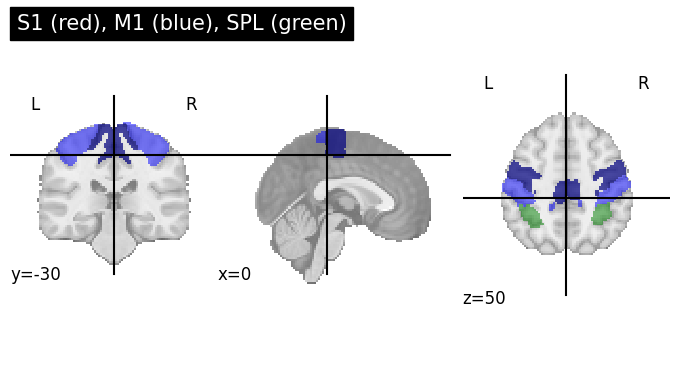

In [11]:
roi_masks = []
colors = ["red", "blue", "green"]

for idx in roi_indices:
    mask = math_img("img == %d" % idx, img=atlas_img)
    roi_masks.append(mask)

display = plotting.plot_roi(roi_masks[0], colorbar=False,
                            title="S1 (red), M1 (blue), SPL (green)",
                            cut_coords=(0, -30, 50))

for mask, color in zip(roi_masks[1:], colors[1:]):
    display.add_overlay(mask, cmap=plotting.cm.alpha_cmap(color))

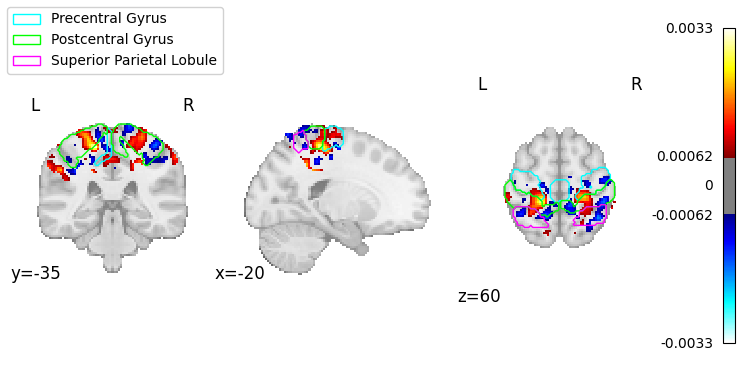

In [12]:
# Plot weight map
threshold = np.percentile(np.abs(coef_img.get_fdata()), 99)
display = plotting.plot_stat_map(
    coef_img,
    threshold=threshold,
    display_mode="ortho",
    cut_coords=(-20, -35, 60),
    cmap="cold_hot",
    draw_cross=False,
)

# Add contours for the three ROIs
colors = ["cyan", "lime", "magenta"]


for roi_idx, color in zip(roi_indices, colors):
    # Create a binary mask for this specific ROI

    roi_mask = (atlas_data == roi_idx).astype(int)
    
    # Create a new image with just this ROI
    from nilearn import image
    roi_img = image.new_img_like(atlas_img, roi_mask)
    
    # Add contours to the display
    display.add_contours(
        roi_img,
        levels=[0.5],
        colors=color,
        linewidths=1
    )



# Add legend - access the figure to place it properly
legend_elements = [Patch(facecolor='none', edgecolor=color, linewidth=1, label=labels[roi_idx])
                   for roi_idx, color in zip(roi_indices, colors)]

# Get the figure and place legend in figure coordinates
fig = plt.gcf()
fig.legend(handles=legend_elements, loc='upper left', framealpha=0.9, fontsize=10)
fig.savefig('svm_weights_with_roi_contours.png', dpi=600, bbox_inches='tight')


plotting.show()

In [13]:
%load_ext watermark

%watermark
%watermark --iversions

Last updated: 2025-10-08T20:03:34.827839+00:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.4.0-204-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

matplotlib: 3.8.4
numpy     : 1.26.4
sklearn   : 1.7.2
nilearn   : 0.12.1

